## 021 Compare performance of EVRPE and CEC to EVRPE-CEC joint models (single subject)

Date: 05.Aug.2022

### Purpose

Compare the performance of CEC-only and EVRPE-only models to mixed EVRPE-CEC models.

### Outline of Plan

1. Copy BiasedCEC, HeuCEC, RWCEC, A0B, A1B, A2B from NB#020.
2. Implement A0BCEC, A1BCEC, A2BCEC models.
3. Prediction visualization and model comparison.

### What we did in this notebook

1. Defined a MixedPrototype in which EVRPE and CEC predictors of craving both occur.
2. Created the next version of slurm_batch (6_slurm_batch, models_6.py)
3. Implemented mixed A0B... all child classes.
4. Model comparison and likelihood comparisons, visualization of predictions, correlations with true.

### Overall conclusions
1. The WAIC performance of EVRPE-CEC models is still not as high as the CEC only models (at least for subject 8).
2. This could be because the other samples from the posterior lead to low mean WAIC, but the best estimate is superior to CEC.
3. The correlations between predicted craving and true craving are extraordinarily better for EVRPE models compared to CEC models (r~0.5 vs r~0.2), suggesting that model fit should be better for EVRPE models.

In [1]:
%load_ext autoreload
%autoreload 2
import numpy as np
import pandas as pd
import pymc as pm
import aesara.tensor as at
import aesara
from scipy import stats
import time
import arviz as az

from abc import ABC, abstractmethod

from sys import path
import os

root_dir = "/Users/kulkarnik/LocalProjects/SlotsTasks/"
project_dir = f'{root_dir}/online/prolific-food-craving/'
model_functions_path = f'{root_dir}/bayesian_models/slotscraving/'

## Add model_functions to system path
path.append(model_functions_path)

from sepblock_decision.utils import load_data # type: ignore

from latest_models_binomial import RetroPrototype

In [2]:
import seaborn as sns
import matplotlib.pyplot as plt
import arviz as az

## Load data

In [3]:
path_to_summary = f'{project_dir}/rawdata/clean_df_summary.csv'
path_to_longform = f'{project_dir}/rawdata/clean_df_longform.csv'
df_summary, longform = load_data.load_clean_dbs(path_to_summary, path_to_longform)
df_summary = df_summary[
    (df_summary['Money Accuracy']>0.5) & 
    (df_summary['Other Accuracy']>0.5)]
longform = longform[(longform['pid_db'].isin(df_summary['id'])) & (longform['Type']!='practice')]
pid_list = longform['PID'].unique()
print(pid_list.shape)
longform

(36,)


,PID,id,Block,Type,Trial,Cue Time,Action,Action Time,Reward,Reward Time,RT,Spin Speed,Craving Rating,Mood Rating,pid_db
5,61281debe85082cc937dd9ae,6,1,other,1,1.647963e+09,1,1.647963e+09,1,1.647963e+09,0.972,fast,-1.0,-1.0,1
6,61281debe85082cc937dd9ae,7,1,other,2,1.647963e+09,1,1.647963e+09,0,1.647963e+09,0.045,fast,35.0,-1.0,1
7,61281debe85082cc937dd9ae,8,1,other,3,1.647963e+09,0,1.647963e+09,1,1.647963e+09,0.718,slow,-1.0,-1.0,1
8,61281debe85082cc937dd9ae,9,1,other,4,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.030,slow,-1.0,-1.0,1
9,61281debe85082cc937dd9ae,10,1,other,5,1.647963e+09,0,1.647963e+09,0,1.647963e+09,0.500,fast,34.0,18.0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5620,6102d5e6ff92a8dd0cce6b8f,5700,2,other,56,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.754,slow,-1.0,-1.0,47
5621,6102d5e6ff92a8dd0cce6b8f,5701,2,other,57,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.637,slow,-1.0,-1.0,47
5622,6102d5e6ff92a8dd0cce6b8f,5702,2,other,58,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.505,fast,-1.0,-1.0,47
5623,6102d5e6ff92a8dd0cce6b8f,5703,2,other,59,1.648471e+09,1,1.648471e+09,1,1.648471e+09,0.652,fast,-1.0,-1.0,47


## Define null model classes

In [4]:
class BiasedCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Biased_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Biased'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def right_action_probs(self, actions, rewards, *args):
        
        sample_bias, weight_zero, weight_one = args

        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        probs = at.repeat(sample_bias, t_actions.shape[0])
        pred_cravings = weight_zero + weight_one*t_rewards

        return probs[1:],  pm.invlogit(pred_cravings)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_bias = pm.Normal('untr_bias', mu=0, sigma=1)
        bias = pm.Deterministic('bias', pm.math.invlogit(untr_bias))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return bias, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [5]:
class HeuCEC:
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'Heuristic_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'Heuristic'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def add_eps(self, st, a, eps_t, eps):
        return aesara.ifelse.ifelse(
                at.eq(st, 1),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    eps,
                    1-eps
                ),
                aesara.ifelse.ifelse(
                    at.eq(a, 1),
                    1-eps,
                    eps
                )
            )
    
    def right_action_probs(self, actions, rewards, strat, *args):
        
        sample_eps, weight_zero, weight_one = args

        t_strat = at.as_tensor_variable(strat, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')

        # Compute the Qs values
        t_eps = at.as_tensor_variable(np.asarray(1, 'float64'))
        t_eps, updates = aesara.scan(
            fn=self.add_eps,
            sequences=[t_strat, t_actions],
            outputs_info=t_eps,
            non_sequences=[sample_eps])
        
        pred_cravings = weight_zero + weight_one*t_rewards

        return t_eps[1:],  pm.invlogit(pred_cravings)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    def _define_priors(self):
        untr_eps = pm.Normal('untr_eps', mu=0, sigma=1)
        eps = pm.Deterministic('eps', pm.math.invlogit(untr_eps))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return eps, weight_zero, weight_one
        

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        strat = np.zeros(len(act))
        for i, a in enumerate(act):
            if i < 2:
                continue
            should_switch = np.all(np.array([rew[i-2]==rew[i-1], rew[i-1]==0]), axis=0)
            do_switch = act[i-1]!=act[i]
            strat[i] = should_switch==do_switch
        strat = strat.astype(int)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, strat, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [7]:
class RWCEC():
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = 'RW_CEC'        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        self.type = 'null'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'CEC'

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1 = args

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + alpha * (pe))
        return Qs

    def right_action_probs(self, actions, rewards, beta, *args):
        alpha, weight_zero, weight_one = args
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.invlogit(loopvals[:, 2])
        t_pred_craving = weight_zero + weight_one*t_rewards

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  pm.math.invlogit(t_pred_craving)
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        return beta, alpha, weight_zero, weight_one

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

## Retrospective prototype class imports

In [8]:
## Standard binomial classes
from latest_models_binomial import RetroPrototype
from latest_models_binomial import A_RW_0step as A0B
from latest_models_binomial import A_RW_1stepSep as A1B
from latest_models_binomial import A_RW_2stepSep as A2B

## Batchfit class
from latest_models_normal import BatchFit

## EVRPE-CEC mixed models

In [9]:
class MixedPrototype(ABC):
    def __init__(self, longform, summary, project_dir, save_path):
        self.name = None        
        self.longform = longform
        self.summary = summary
        self.pid_list = longform['PID'].unique()
        self.traces = {
            'money': {},
            'other': {}
        }
        self.project_dir = project_dir

        num_craving_trials = 20
        num_blocks = 2
        self.craving_inds = None
        self.mean_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.std_craving = np.zeros((num_blocks, len(self.pid_list)))
        self.norm_cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self.cravings = np.zeros((num_blocks, len(self.pid_list), num_craving_trials))
        self._calc_norm_cravings()

        self.save_path = save_path
    
    def _calc_norm_cravings(self):
        for pid_num in range(len(self.pid_list)):
            for b, block in enumerate(['money', 'other']):
                pid = self.pid_list[pid_num]
                cravings = self.longform[(self.longform['PID']==pid)&(self.longform['Type']==block)]['Craving Rating'].values
                craving_inds = np.squeeze(np.argwhere(cravings>-1))
                mask = np.ones(len(craving_inds), dtype=bool)
                mask[12] = False
                craving_inds = craving_inds[mask]
                cravings = cravings[craving_inds]
                self.craving_inds = craving_inds
                self.mean_craving[b, pid_num] = np.mean(cravings)
                self.std_craving[b, pid_num] = np.std(cravings)
                self.norm_cravings[b, pid_num, :] = stats.zscore(cravings)
                self.cravings[b, pid_num, :] = cravings

    @abstractmethod
    def update_Q(self, a, r, Qs, *args):
        pass

    def right_action_probs(self, actions, rewards, beta, cec_weight, *args):
        # Note that the first parameter is always the sample_beta, it is a required argument
        # Note that the second parameter is always the weight assigned to the cue-induced effect
        t_rewards = at.as_tensor_variable(rewards, dtype='int32')
        t_actions = at.as_tensor_variable(actions, dtype='int32')

        # Compute all loop vals
        # 0 - Q[left]
        # 1 - Q[right]
        # 2 - pred_craving
        # 3 - Q[t-1]
        # 4 - Q[t-2]
        # 5 - PE[t-1]
        # 6 - PE[t-2]
        loopvals =  at.zeros((7,), dtype='float64')
        loopvals, updates = aesara.scan(
            fn=self.update_Q,
            sequences=[t_actions, t_rewards],
            outputs_info=[loopvals],
            non_sequences=[*args])
        t_Qs = loopvals[:, :2]
        # t_pred_craving = pm.math.invlogit(loopvals[:, 2]) ## RETROPROTOTYPE VERSION ##
        t_pred_craving = pm.invlogit(loopvals[:, 2] + cec_weight*t_rewards) ## MIXEDPROTOTYPE VERSION ##

        # Apply the sotfmax transformation
        t_Qs = t_Qs[:-1] * beta
        logp_actions = t_Qs - at.logsumexp(t_Qs, axis=1, keepdims=True)

        # Return the probabilities for the right action, in the original scale
        # Return predicted cravings
        return at.exp(logp_actions[:, 1]),  t_pred_craving
    
    def _load_act_rew_craving(self, pid_num, block, norm=True):
        pid = self.pid_list[pid_num]
        b = 0 if block=='money' else 1
        act = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Action'].values
        rew = self.longform[(self.longform['PID']==pid) & (self.longform['Type']==block)]['Reward'].values
        if norm:
            crav = self.norm_cravings[b, pid_num, :]
        else:
            crav = self.cravings[b, pid_num, :]
        return act, rew, crav
    
    @abstractmethod
    def _define_priors(self):
        # Beta must be returned first!
        pass

    def fit(self, pid_num, block):
        pid = self.pid_list[pid_num]
        if self.save_path is not None:
            if not os.path.exists(f'{self.save_path}/{self.name}/'):
                os.makedirs(f'{self.save_path}/{self.name}/')
            filestr = f'{self.save_path}/{self.name}/{block}_{pid}.nc'
            if os.path.exists(filestr):
                print(f'PID: {pid}, Block {block} exists, loading from file...')
                self.traces[block][pid] = az.from_netcdf(filestr)
                return
        act, rew, cravings = self._load_act_rew_craving(pid_num, block, norm=False)
        with pm.Model() as model:
            priors = self._define_priors()
            action_probs, craving_pred = self.right_action_probs(act, rew, *priors)

            like = pm.Bernoulli('like', p=action_probs, observed=act[1:])
            craving_like = pm.Binomial('craving_like', n=50, p=craving_pred[self.craving_inds-1], observed=cravings)
            
            self.traces[block][pid] = pm.sample(step=pm.Metropolis())
            # self.traces[block][pid].extend(pm.sample_prior_predictive())
            pm.sample_posterior_predictive(self.traces[block][pid], extend_inferencedata=True)
            if self.save_path is not None:
                self.traces[block][pid].to_netcdf(filestr)

In [10]:
class A0BCEC(MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_0step_CEC'
        self.type = 'active_lr'
        self.retro = 0
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'

    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(Qs[2], w0 + w1 * Qs[a] + w2 * pe)

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, mod


In [11]:
class A1BCEC(MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_1stepSep_CEC'
        self.type = 'active_lr'
        self.retro = 1
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*pe + w4*Qs[5]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, mod


In [12]:
class A2BCEC(MixedPrototype):
    def __init__(self, *args):
        super().__init__(*args)
        self.name = 'A_RW_2stepSep_CEC'
        self.type = 'active_lr'
        self.retro = 2
        self.decision = 'RW'
        self.craving = 'EVRPE_CEC'
    
    def update_Q(self, a, r, Qs, *args):
        # Note that beta is not present in the args list
        alpha, w0, w1, w2, w3, w4, w5, w6, mod = args

        ## Calculate the bias associated with the current craving
        bias = mod*pm.math.invlogit(Qs[2])

        ## Update the Q values - Single update (RW)
        # Calculate trial RPE
        # Qs at indices 0 (left) and 1 (right)
        pe = r - Qs[a]
        Qs = at.set_subtensor(Qs[a], Qs[a] + (alpha+bias) * (pe))

        ## Calculate predicted craving - TWO STEP (Retro2) - at index 2
        Qs = at.set_subtensor(
            Qs[2], 
            w0 + w1*Qs[a] + w2*Qs[3] + w3*Qs[4] + w4*pe + w5*Qs[5] + w6*Qs[6]
        )

        # Set PE[t-2] at index 6 with PE[t-1] at index 5
        Qs = at.set_subtensor(Qs[6], Qs[5])
        # Set PE[t-1] at index 5 with trial PE
        Qs = at.set_subtensor(Qs[5], pe)
        # Set Qs[t-2] at index 4 with Qs[t-1] at index 3
        Qs = at.set_subtensor(Qs[4], Qs[3])
        # Set Qs[t-1] at index 3 with trial chosen Q
        Qs = at.set_subtensor(Qs[3], Qs[a])
        
        return Qs

    def _define_priors(self):
        beta = pm.HalfNormal('beta', 10)
        untr_alpha = pm.Normal('untr_alpha', mu=0, sigma=1)
        alpha = pm.Deterministic('alpha', pm.math.invlogit(untr_alpha))
        cec_weight = pm.Normal('cec_weight', mu=0, sigma=1)
        weight_zero = pm.Normal('weight_zero', mu=0, sigma=1)
        weight_one = pm.Normal('weight_one', mu=0, sigma=1)
        weight_two = pm.Normal('weight_two', mu=0, sigma=1)
        weight_three = pm.Normal('weight_three', mu=0, sigma=1)
        weight_four = pm.Normal('weight_four', mu=0, sigma=1)
        weight_five = pm.Normal('weight_five', mu=0, sigma=1)
        weight_six = pm.Normal('weight_six', mu=0, sigma=1)
        mod = pm.LogNormal('mod', mu=0, sigma=0.5)
        return beta, cec_weight, alpha, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, mod


## Fit models

In [13]:
save_path_nb21 = f'{model_functions_path}/exploration/21_trace_output/'
biasedcec = BiasedCEC(longform, df_summary, project_dir, save_path_nb21)
heucec = HeuCEC(longform, df_summary, project_dir, save_path_nb21)
rwcec = RWCEC(longform, df_summary, project_dir, save_path_nb21)
a0b = A0B(longform, df_summary, project_dir, save_path_nb21)
a1b = A1B(longform, df_summary, project_dir, save_path_nb21)
a2b = A2B(longform, df_summary, project_dir, save_path_nb21)
a0bcec = A0BCEC(longform, df_summary, project_dir, save_path_nb21)
a1bcec = A1BCEC(longform, df_summary, project_dir, save_path_nb21)
a2bcec = A2BCEC(longform, df_summary, project_dir, save_path_nb21)

In [14]:
for pid_num in [8]:
    for model in [a0bcec, a1bcec, a2bcec, biasedcec, heucec, rwcec, a0b, a1b, a2b]:
        model.fit(pid_num, 'other')

PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...
PID: 612682ec747ac2d5df40f7df, Block other exists, loading from file...


## Output posterior

In [15]:
pid_num = 8

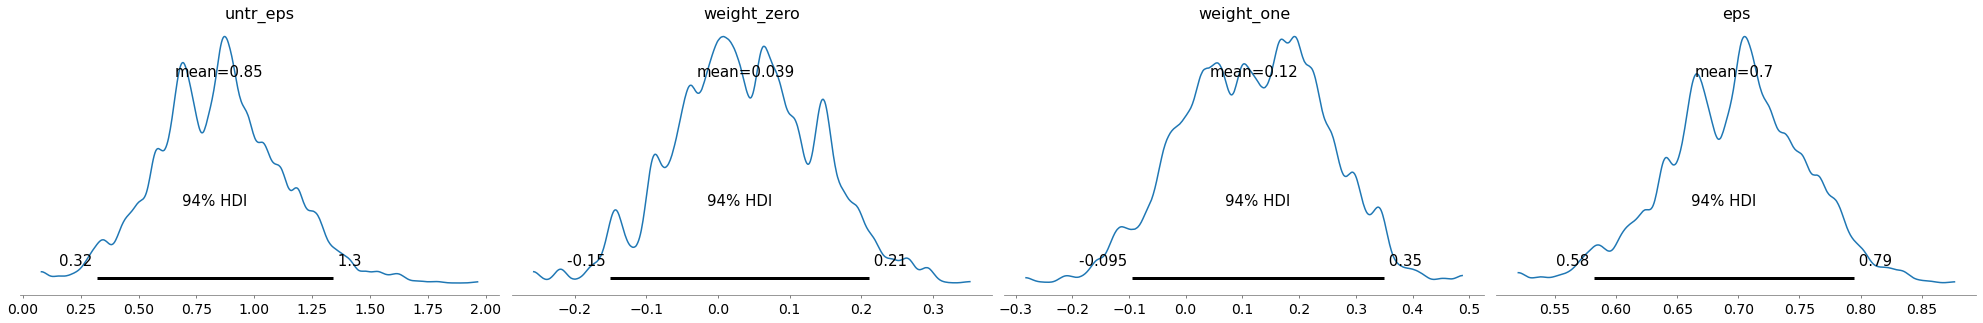

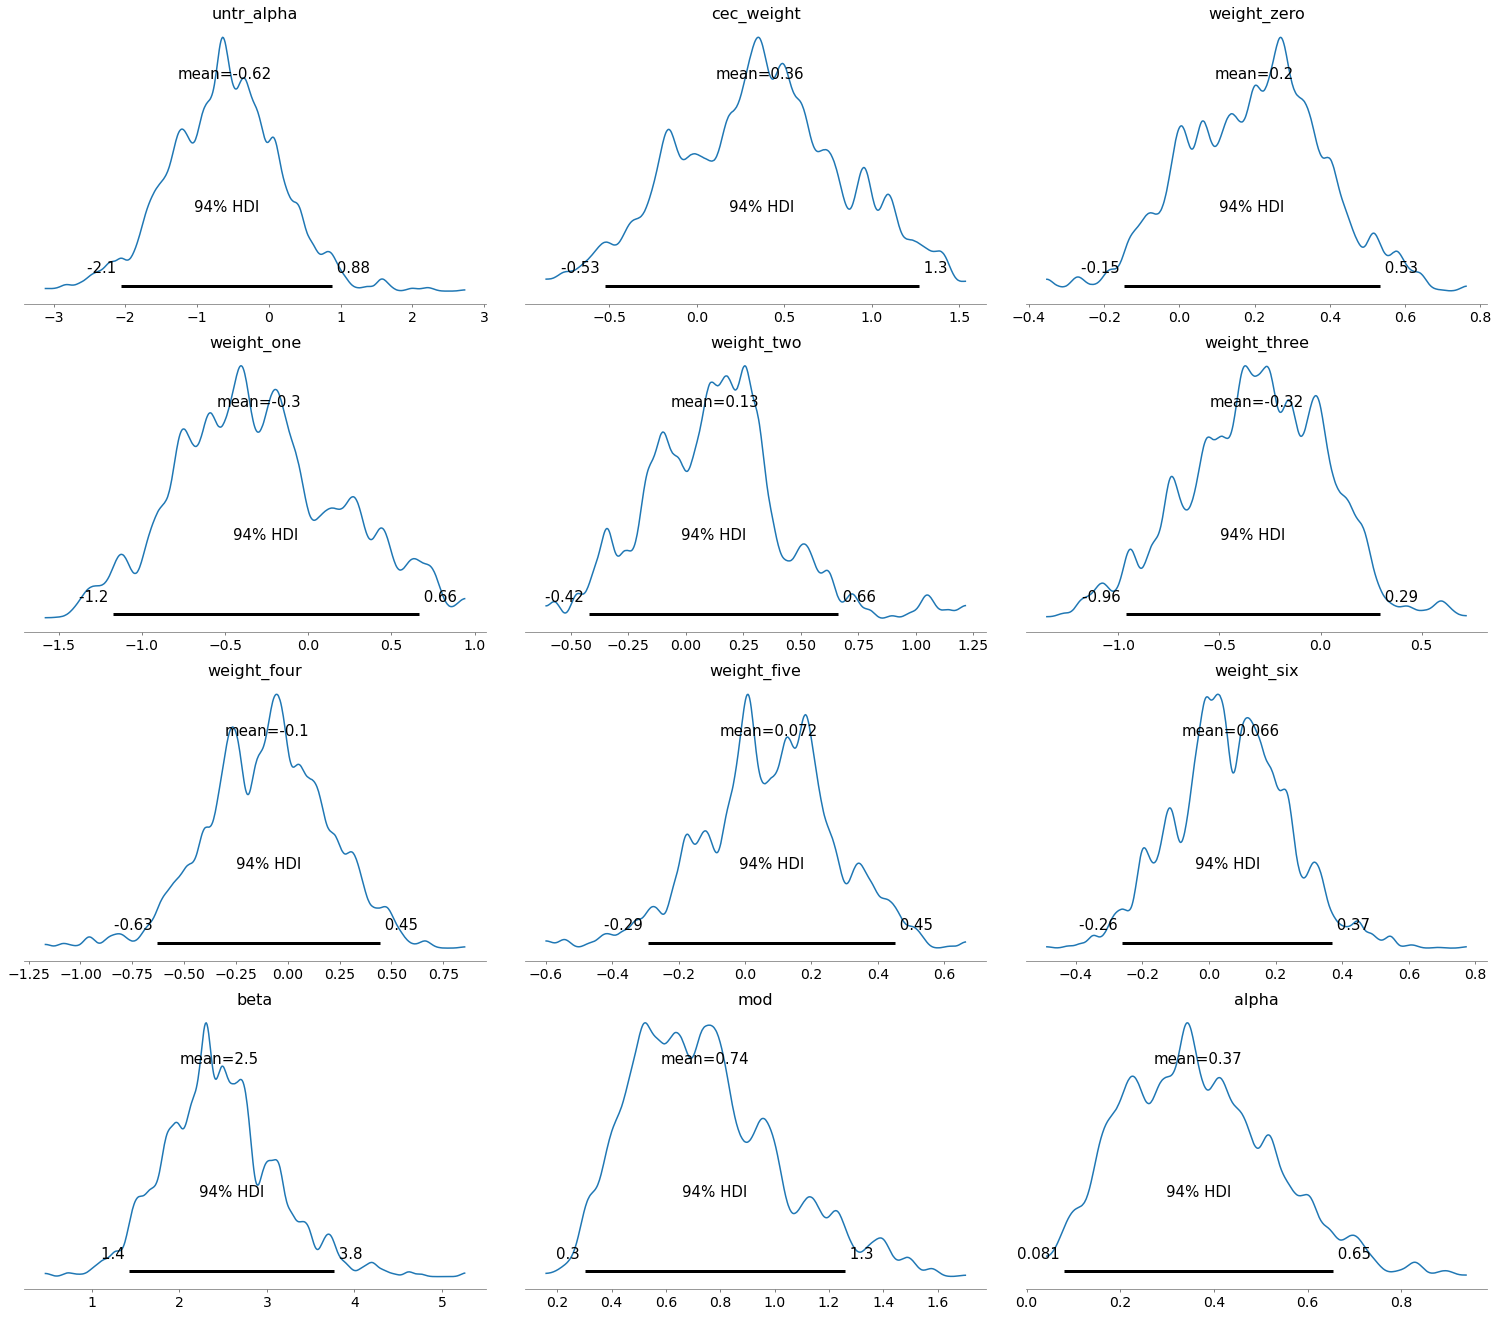

In [16]:
# az.plot_posterior(activev1_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
# az.plot_posterior(activev2_2step_model.traces['other'][pid_list[pid_num]])
# plt.tight_layout()
az.plot_posterior(heucec.traces['other'][pid_list[pid_num]])
plt.tight_layout()
az.plot_posterior(a2bcec.traces['other'][pid_list[pid_num]])
plt.tight_layout()


## Plotting utils

In [17]:
def plot_ppc_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.cravings[b, pid_num].shape[0]),
        y=samp_model.cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


In [18]:
def plot_ppc_norm_craving(models, pid_num, block):
    b = 0 if block=='money' else 1
    fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
    model_names = [m.name for m in models]
    samp_model = models[0]
    sns.lineplot(
        x=np.arange(samp_model.norm_cravings[b, pid_num].shape[0]),
        y=samp_model.norm_cravings[b, pid_num],
        label='True craving',
        color='black'
    )
    for i, model in enumerate(models):
        sns.lineplot(
            x=np.arange(len(model.norm_cravings[b, pid_num])),
            y=model.traces[block][model.pid_list[pid_num]].posterior_predictive.craving_like.values[0].mean(axis=0),
            label=f'{model_names[i]}'
        )
    plt.tight_layout()
    plt.close()
    return fig


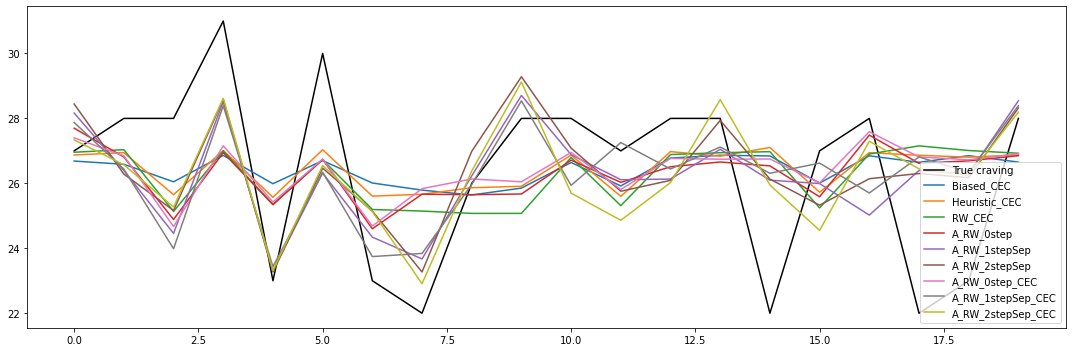

In [19]:
plot_ppc_craving([
    biasedcec, heucec, rwcec,
    a0b, a1b, a2b,
    a0bcec, a1bcec, a2bcec
], pid_num, 'other')

In [20]:
for model in [biasedcec, heucec, rwcec, a0b, a1b, a2b, a0bcec, a1bcec, a2bcec]:
    print(model.name, stats.pearsonr(
        model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like[2].mean(axis=0).values,
        model.cravings[1, pid_num]
    ))

Biased_CEC (0.2661473866420568, 0.25670427993953915)
Heuristic_CEC (0.29958772953307455, 0.1994056545807681)
RW_CEC (0.23851474445370616, 0.3112030241399919)
A_RW_0step (0.3019195798838319, 0.1957593665499204)
A_RW_1stepSep (0.5493036464416143, 0.012120590173544107)
A_RW_2stepSep (0.580417714687502, 0.007294242641914274)
A_RW_0step_CEC (0.34288925379251806, 0.13887059475034164)
A_RW_1stepSep_CEC (0.5140675105161677, 0.020408595118359275)
A_RW_2stepSep_CEC (0.5587929672939032, 0.010434049044862791)


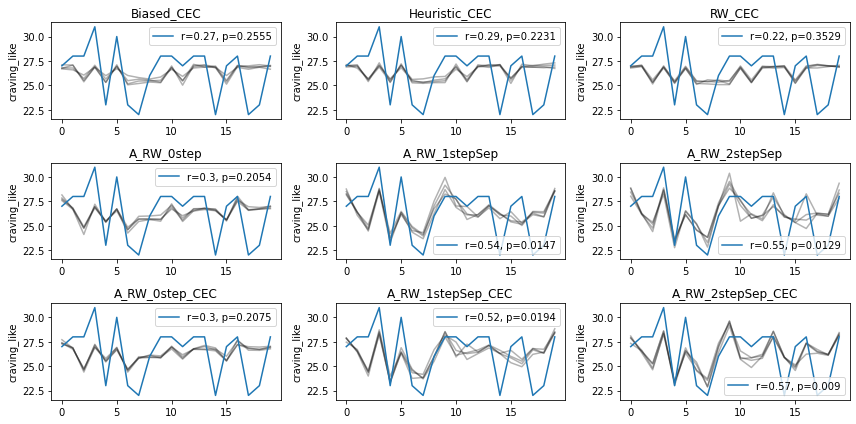

In [21]:
fig, ax = plt.subplots(ncols=3, nrows=3, figsize=(12,6), facecolor='w', edgecolor='k')

for i, model in enumerate([biasedcec, heucec, rwcec, a0b, a1b, a2b, a0bcec, a1bcec, a2bcec]):
    rs = []
    ps = []
    for trace in model.traces['other'][pid_list[pid_num]].posterior_predictive.craving_like:
        r, p = stats.pearsonr(trace.mean(axis=0), model.cravings[1, pid_num])
        rs.append(r)
        ps.append(p)
        sns.lineplot(
            x=np.arange(len(model.cravings[1, pid_num])), 
            y=trace.mean(axis=0), ax=ax[i//3, i%3], 
            color='black', alpha=0.3)
    sns.lineplot(
        x=np.arange(len(model.cravings[1, pid_num])), 
        y=model.cravings[1, pid_num], 
        label=f'r={np.round(np.mean(rs), 2)}, p={np.round(np.mean(ps), 4)}', 
        ax=ax[i//3, i%3])
    ax[i//3, i%3].set_title(model.name)

plt.tight_layout()

## Model comparison of EV and EVRPE

In [22]:
biasedcec.traces['other'][pid_list[pid_num]].log_likelihood.craving_like.values.shape

(4, 1000, 20)

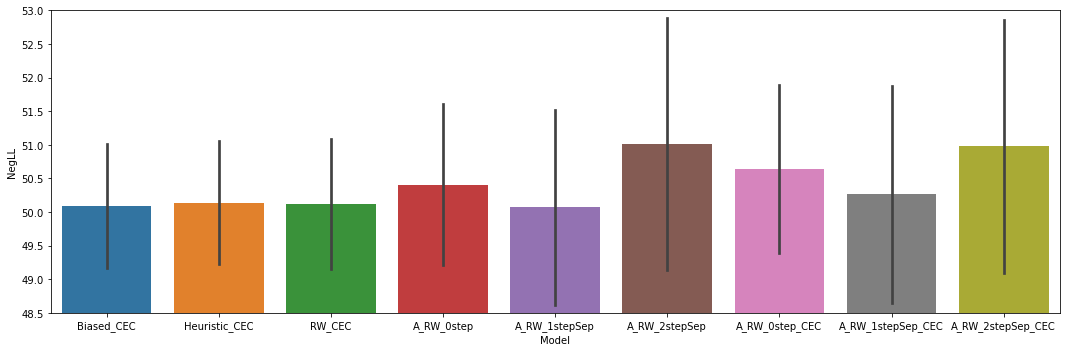

In [23]:
model_names = []
lls = []
for model in [biasedcec, heucec, rwcec, a0b, a1b, a2b, a0bcec, a1bcec, a2bcec]:
    for trace in model.traces['other'][pid_list[pid_num]].log_likelihood.craving_like.values:
        for samp in trace:
            model_names.append(model.name)
            lls.append(-samp.sum())

ll_df = pd.DataFrame({'Model': model_names, 'NegLL': lls})
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(15,5), facecolor='w', edgecolor='k')
sns.barplot(data=ll_df, x='Model', y='NegLL', ci='sd', ax=ax)
ax.set_ylim(48.5,53)
plt.tight_layout()

In [24]:
ll_df.groupby('Model').agg({'NegLL': ['mean', 'std']})

NegLL          
                        mean       std
Model                                 
A_RW_0step         50.407963  1.195219
A_RW_0step_CEC     50.638636  1.250662
A_RW_1stepSep      50.067944  1.444573
A_RW_1stepSep_CEC  50.266085  1.611962
A_RW_2stepSep      51.008028  1.873056
A_RW_2stepSep_CEC  50.977655  1.877880
Biased_CEC         50.092291  0.926619
Heuristic_CEC      50.138263  0.914068
RW_CEC             50.115902  0.966288

In [25]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Active0': a0b.traces['other'][pid_list[pid_num]],
        'Active1': a1b.traces['other'][pid_list[pid_num]],
        'Active2': a2b.traces['other'][pid_list[pid_num]],
        'Active0CEC': a0bcec.traces['other'][pid_list[pid_num]],
        'Active1CEC': a1bcec.traces['other'][pid_list[pid_num]],
        'Active2CEC': a2bcec.traces['other'][pid_list[pid_num]]
    },
    ic='waic',
    var_name='craving_like'
)
model_comp

/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(
/Users/kulkarnik/miniconda3/envs/pymc_env/lib/python3.10/site-packages/arviz/stats/stats.py:1661: UserWarning: For one or more samples the posterior variance of the log predictive densities exceeds 0.4. This could be indication of WAIC starting to fail. 
See http://arxiv.org/abs/1507.04544 for details
  warnings.warn(


,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Biased,0,-50.679256,1.081683,0.000000,1.0,1.450796,0.000000,False,log
RWCEC,1,-50.719682,1.109943,0.040426,0.0,1.430469,0.080531,False,log
Heuristic,2,-50.745162,1.120070,0.065906,0.0,1.488087,0.065048,False,log
Active0,3,-51.287217,1.552551,0.607962,0.0,1.394199,0.521170,False,log
Active1,4,-51.335397,2.145994,0.656141,0.0,1.099871,1.137826,False,log
Active0CEC,5,-51.639963,1.767711,0.960708,0.0,1.468699,0.503675,False,log
Active1CEC,6,-51.641241,2.307149,0.961985,0.0,1.258410,1.088906,False,log
Active2CEC,7,-53.013818,3.290846,2.334562,0.0,1.017792,1.133509,True,log
Active2,8,-53.047742,3.303528,2.368486,0.0,0.980834,1.229653,True,log


<AxesSubplot:xlabel='Log'>

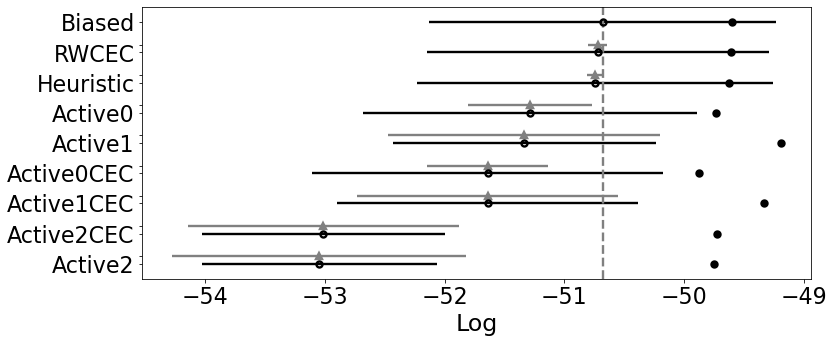

In [26]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))

In [27]:
model_comp = az.compare({
        'Biased': biasedcec.traces['other'][pid_list[pid_num]],
        'Heuristic': heucec.traces['other'][pid_list[pid_num]],
        'RWCEC': rwcec.traces['other'][pid_list[pid_num]],
        'Active0': a0b.traces['other'][pid_list[pid_num]],
        'Active1': a1b.traces['other'][pid_list[pid_num]],
        'Active2': a2b.traces['other'][pid_list[pid_num]],
        'Active0CEC': a0bcec.traces['other'][pid_list[pid_num]],
        'Active1CEC': a1bcec.traces['other'][pid_list[pid_num]],
        'Active2CEC': a2bcec.traces['other'][pid_list[pid_num]]
    },
    ic='waic',
    var_name='like'
)
model_comp

,rank,waic,p_waic,d_waic,weight,se,dse,warning,waic_scale
Active0,0,-28.209011,1.544323,0.000000,7.631963e-01,4.676191,0.000000,False,log
Active2,1,-28.252049,1.530443,0.043038,1.454543e-15,4.543497,0.177101,False,log
Active1CEC,2,-28.257273,1.610968,0.048262,0.000000e+00,4.636659,0.073519,False,log
RWCEC,3,-28.258509,1.528735,0.049498,1.677924e-01,4.563940,0.599356,False,log
Active0CEC,4,-28.273547,1.599494,0.064536,8.223169e-16,4.590468,0.203743,False,log
Active1,5,-28.320267,1.601934,0.111255,6.046853e-15,4.566341,0.139350,False,log
Active2CEC,6,-28.356254,1.633954,0.147243,1.184232e-14,4.578064,0.397593,False,log
Heuristic,7,-36.358505,0.898213,8.149493,1.588418e-14,2.996392,3.932075,False,log
Biased,8,-38.628946,0.826916,10.419935,6.901139e-02,2.291249,4.645159,False,log


<AxesSubplot:xlabel='Log'>

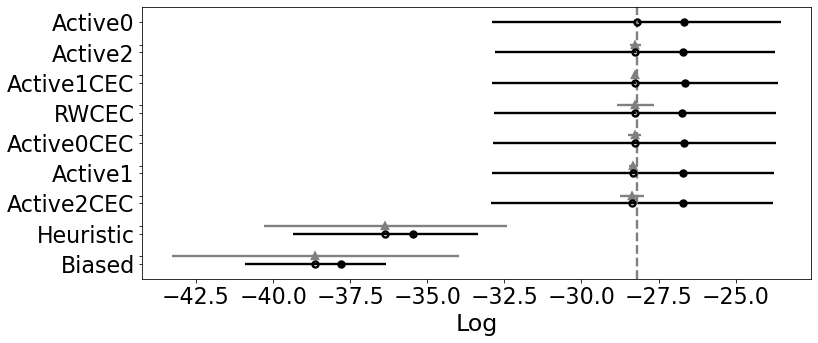

In [28]:
az.plot_compare(model_comp,insample_dev=True, figsize=(12,5))

In [107]:
a2bcec_vars = []
for var in a2bcec.traces['other'][pid_list[pid_num]].posterior.data_vars:
    print(var)
    print(a2bcec.traces['other'][pid_list[pid_num]].posterior[var].values.mean())
    a2bcec_vars.append(a2bcec.traces['other'][pid_list[pid_num]].posterior[var].values.mean())
    # print(a0bcec.traces['other'][pid_list[pid_num]].posterior[var].values.std())
    # print()
    # a0bcec.generate_map_pp()

untr_alpha
-0.6172194298272319
cec_weight
0.3628914433791842
weight_zero
0.19902950025817145
weight_one
-0.29865166255955533
weight_two
0.12759861763750954
weight_three
-0.3170107779101583
weight_four
-0.1012136379335851
weight_five
0.07218183204335726
weight_six
0.06585689623246165
beta
2.457907088198488
mod
0.7420589387163898
alpha
0.36641238274299165


In [67]:
from scipy.special import expit

In [108]:
act, rew, rate = a2bcec._load_act_rew_craving(pid_num=pid_num, block='other', norm=False)
untr_alpha, cec_weight, weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six, beta, mod, alpha = a2bcec_vars
alpha = expit(untr_alpha)

In [109]:
print(alpha)
print(beta)
print(weight_zero, weight_one, weight_two, weight_three, weight_four, weight_five, weight_six)
print(cec_weight)
print(mod)

0.3504141125514121
2.457907088198488
0.19902950025817145 -0.29865166255955533 0.12759861763750954 -0.3170107779101583 -0.1012136379335851 0.07218183204335726 0.06585689623246165
0.3628914433791842
0.7420589387163898


In [125]:
Qs = np.zeros((len(act), 7))
# Compute all loop vals
# 0 - Q[left]
# 1 - Q[right]
# 2 - pred_craving
# 3 - Q[t-1]
# 4 - Q[t-2]
# 5 - PE[t-1]
# 6 - PE[t-2]
for i, (a, r) in enumerate(zip(act, rew)):
    bias = mod*expit(Qs[i-1, 2])
    print(alpha+bias)
    pe = r - Qs[i-1, a]
    Qs[i, a] = Qs[i-1, a] + (alpha+bias) * pe
    Qs[i, 1-a] = Qs[i-1, 1-a]
    Qs[i, 2] = weight_zero + weight_one*Qs[i, a] + weight_one*Qs[i-1,3] + weight_three*Qs[i-1, 4] + weight_four*pe + weight_five*Qs[i-1, 5] + weight_six*Qs[i-1, 6] 

    Qs[i, 6] = Qs[i-1, 5]
    Qs[i, 5] = pe
    Qs[i, 4] = Qs[i-1, 3]
    Qs[i, 3] = Qs[i, a]
    

0.721443581909607
0.6996439374543364
0.6760161033892292
0.6277171630374889
0.6039282003395303
0.5972904717111205
0.5952743484863856
0.5945775934583196
0.641922372023845
0.6123318301558074
0.6846863979145165
0.6370955621884942
0.6429405700390602
0.6201767564642782
0.6030828824761219
0.6456718840233708
0.6656285336130389
0.7102624045316154
0.6829581131276341
0.6725018835694873
0.628909324715442
0.6047354755988935
0.5976256994655382
0.6432581005721454
0.6648253603623125
0.7211047592347187
0.757509397398316
0.7468392564912181
0.743903442800011
0.6953134227605283
0.7304018537956879
0.6699250192050735
0.6546868324645131
0.654261359788231
0.64709280096124
0.6489792537884984
0.5950148402135693
0.6420892224746523
0.6123904439788297
0.6356113968933541
0.6449782088968389
0.6382053799490017
0.6100159507521592
0.6491926218110924
0.6208766363057491
0.6229232073644514
0.5948520276167665
0.5943991763900637
0.644275743730816
0.6877449788023888
0.6581382689373778
0.6425696748177148
0.6266077209756179
0.

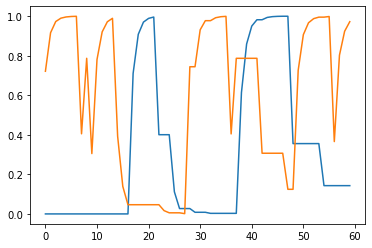

In [123]:
plt.plot(Qs[:, 0])
plt.plot(Qs[:, 1])

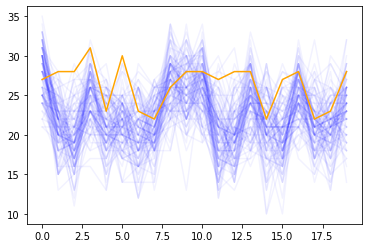

In [127]:
for samp in np.random.binomial(n=50, p=expit(Qs[:, 2] + cec_weight*rew), size=(100, 60)):
    plt.plot(samp[a0bcec.craving_inds-1], color='blue', alpha=0.05)
plt.plot(a0bcec.cravings[1, pid_num, :], color='orange')

In [132]:
expit(cec_weight*rew + Qs[:, 2])

array([0.56100628, 0.52916289, 0.46169771, 0.4272401 , 0.417475  ,
       0.41449575, 0.41346471, 0.39283707, 0.43950815, 0.45046595,
       0.47505482, 0.48331581, 0.45086593, 0.42600021, 0.39788992,
       0.42478354, 0.48493222, 0.53859563, 0.52436306, 0.46340268,
       0.42842319, 0.41796977, 0.3946371 , 0.42370118, 0.4995434 ,
       0.54860236, 0.53422326, 0.53026695, 0.55522519, 0.51207218,
       0.52083286, 0.49977129, 0.40946511, 0.48915488, 0.49179968,
       0.41411182, 0.39306192, 0.43959335, 0.47294944, 0.48618428,
       0.47662712, 0.43613784, 0.40263447, 0.4518748 , 0.45482081,
       0.4138709 , 0.41320057, 0.39600848, 0.4545877 , 0.50456977,
       0.48279305, 0.4601092 , 0.42856865, 0.41841048, 0.39775809,
       0.47011022, 0.4561922 , 0.44042864, 0.47264483, 0.44758158])

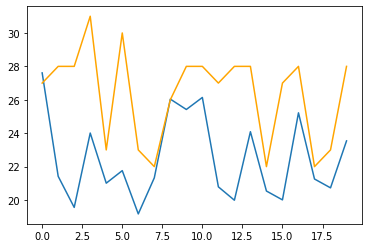

In [119]:
plt.plot(np.random.binomial(n=50, p=expit(Qs[:, 2] + cec_weight*rew), size=(100, 60)).mean(axis=0)[a0bcec.craving_inds-1])
plt.plot(a0bcec.cravings[1, pid_num, :], color='orange')